In [1]:

#data preprocessing
import pandas as pd
#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#displayd data
from IPython.display import display
%matplotlib inline

In [2]:
## steps:
# 1. visualise data
# 2. classify SVM xgboost etc
# 3. validate classifier with confusion matrix

file = 'data/final_dataset.csv'

df = pd.read_csv(file, parse_dates=True)

In [3]:
display(df.keys())

Index(['Unnamed: 0', 'date', 'round', 'home', 'away', 'fthp', 'ftap', 'ftr',
       'htps', 'htpc', 'atps', 'atpc', 'htp', 'atp', 'hm1', 'hm2', 'hm3',
       'hm4', 'hm5', 'am1', 'am2', 'am3', 'am4', 'am5', 'rn', 'htformptsstr',
       'atformptsstr', 'htformpts', 'atformpts', 'HTWinStreak3',
       'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3',
       'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5', 'htgd', 'atgd',
       'diffpts', 'diffformpts'],
      dtype='object')

In [4]:
# dropping redundant column? not sure if this is true
drop_columns = ['Unnamed: 0','date','round','home','away','fthp',
                'ftap','hm4','hm5','am4','am5',
                'rn','htformptsstr','atformptsstr',
                'htformpts','atformpts','HTWinStreak3',
                'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5',
                'ATWinStreak3','ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5']
# keep: FTR	HTP	ATP	HM1	HM2	HM3	AM1	AM2	AM3	HTGD	ATGD	DiffFormPts	DiffLP
data = df.drop(drop_columns, axis=1)

In [5]:
# Preview data.
display(data[30:35])

,ftr,htps,htpc,atps,atpc,htp,atp,hm1,hm2,hm3,am1,am2,am3,htgd,atgd,diffpts,diffformpts
30,NH,92,29,62,51,2.000000,0.666667,V,V,V,L,V,M,10.500000,1.833333,1.333333,1.333333
31,H,37,56,58,65,0.666667,0.666667,L,V,M,V,L,M,-3.166667,-1.166667,0.000000,0.000000
32,H,53,46,58,82,0.857143,0.571429,V,D,L,V,V,L,1.000000,-3.428571,0.285714,-0.285714
33,H,54,56,0,0,1.142857,0.000000,V,L,V,M,M,M,-0.285714,0.000000,1.142857,1.142857
34,H,24,29,12,26,0.571429,0.000000,L,V,M,V,M,M,-0.714286,-2.000000,0.571429,0.000000


In [6]:
#what is the win rate for the home team in Super Rugby?

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.ftr == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 1559
Number of features: 16
Number of matches won by home team: 947
Win rate of home team: 60.74%


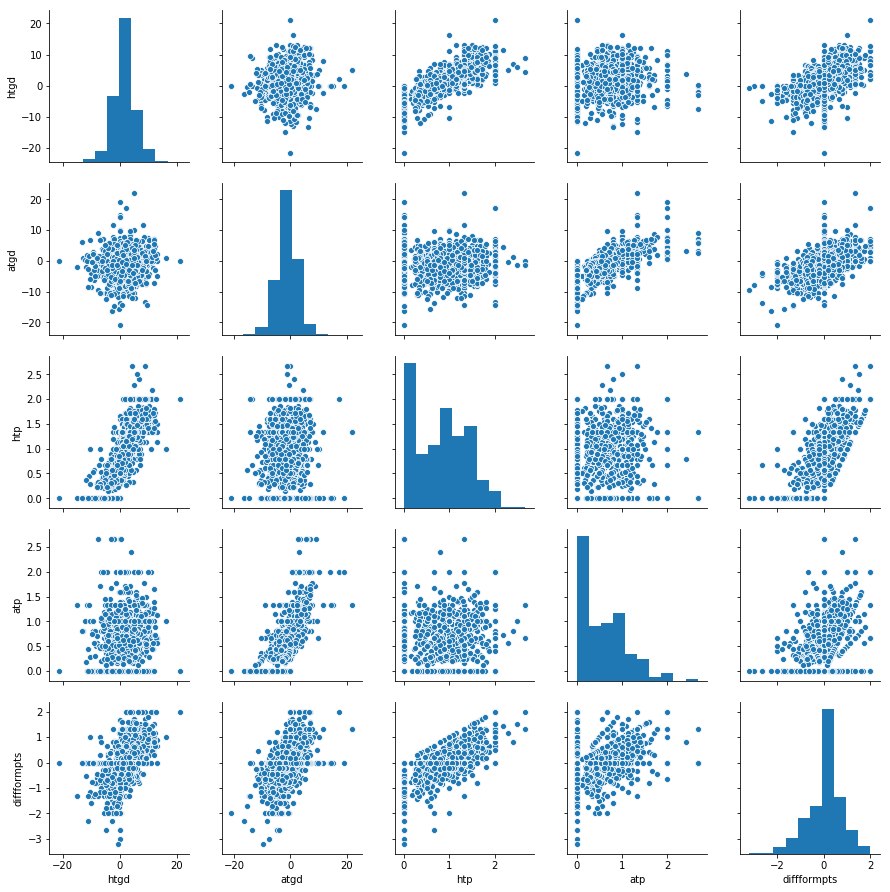

In [7]:
# Visualising distribution of data
import seaborn as sns

#the scatter matrix is plotting each of the columns specified against each other column.
#You would have observed that the diagonal graph is defined as a histogram, which means that in the 
#section of the plot matrix where the variable is against itself, a histogram is plotted.

#Scatter plots show how much one variable is affected by another. 
#The relationship between two variables is called their correlation
#negative vs positive correlation

#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

#print(data.columns)
vis_data = data[['htgd','atgd','htp','atp','diffformpts']]
sns.pairplot(vis_data)

In [8]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['ftr'],1)
y_all = data['ftr']

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['htgd','atgd','htp','atp','diffpts','htps','htpc','atps','atpc']]
for col in cols:
    X_all[col] = scale(X_all[col])
    
display(data[30:35])

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':


,ftr,htps,htpc,atps,atpc,htp,atp,hm1,hm2,hm3,am1,am2,am3,htgd,atgd,diffpts,diffformpts
30,NH,92,29,62,51,2.000000,0.666667,V,V,V,L,V,M,10.500000,1.833333,1.333333,1.333333
31,H,37,56,58,65,0.666667,0.666667,L,V,M,V,L,M,-3.166667,-1.166667,0.000000,0.000000
32,H,53,46,58,82,0.857143,0.571429,V,D,L,V,V,L,1.000000,-3.428571,0.285714,-0.285714
33,H,54,56,0,0,1.142857,0.000000,V,L,V,M,M,M,-0.285714,0.000000,1.142857,1.142857
34,H,24,29,12,26,0.571429,0.000000,L,V,M,V,M,M,-0.714286,-2.000000,0.571429,0.000000


In [9]:
#last 3 wins for both sides
X_all['hm1'] = X_all['hm1'].astype('str')
X_all.hm2 = X_all.hm2.astype('str')
X_all.hm3 = X_all.hm3.astype('str')
X_all.am1 = X_all.am1.astype('str')
X_all.am2 = X_all.am2.astype('str')
X_all.am3 = X_all.am3.astype('str')

#we want continous vars that are integers for our input data, so lets remove any categorical vars
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (34 total features):
['htps', 'htpc', 'atps', 'atpc', 'htp', 'atp', 'hm1_D', 'hm1_L', 'hm1_M', 'hm1_V', 'hm2_D', 'hm2_L', 'hm2_M', 'hm2_V', 'hm3_D', 'hm3_L', 'hm3_M', 'hm3_V', 'am1_D', 'am1_L', 'am1_M', 'am1_V', 'am2_D', 'am2_L', 'am2_M', 'am2_V', 'am3_D', 'am3_L', 'am3_M', 'am3_V', 'htgd', 'atgd', 'diffpts', 'diffformpts']


In [10]:
# Show the feature information by printing the first five rows
print("\nFeature values:")
display(X_all[30:35])


Feature values:


,htps,htpc,atps,atpc,htp,atp,hm1_D,hm1_L,hm1_M,hm1_V,...,am2_M,am2_V,am3_D,am3_L,am3_M,am3_V,htgd,atgd,diffpts,diffformpts
30,0.052097,-0.780312,-0.212114,-0.527729,2.076895,0.240122,0,0,0,1,...,0,1,0,0,1,0,2.276558,0.748927,1.542469,1.333333
31,-0.723702,-0.285410,-0.281223,-0.310002,-0.193498,0.240122,0,1,0,0,...,0,0,0,0,1,0,-1.126930,-0.033133,-0.336805,0.000000
32,-0.498015,-0.468707,-0.281223,-0.045618,0.130844,0.057647,0,0,0,1,...,0,1,0,1,0,0,-0.089281,-0.622781,0.065897,-0.285714
33,-0.483910,-0.285410,-1.283301,-1.320879,0.617357,-1.037204,0,0,0,1,...,1,0,0,0,1,0,-0.409470,0.271001,1.274001,1.142857
34,-0.907073,-0.780312,-1.075974,-0.916528,-0.355669,-1.037204,0,1,0,0,...,1,0,0,0,1,0,-0.516199,-0.250372,0.468598,0.000000


In [11]:
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 50,
                                                    random_state = 2,
                                                    stratify = y_all)

In [23]:
#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score, precision_score, recall_score

#Compute the precision
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
#The best value is 1 and the worst value is 0.

#Compute the recall
#The recall is intuitively the ability of the classifier to find all the positive samples.
#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.
#The best value is 1 and the worst value is 0.
# sklearn.metrics.recall_score(y_true, y_pred, labels=None, pos_label=1, average=’binary’, sample_weight=None)[source]

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred)), precision_score(target, y_pred, pos_label='H'), recall_score(target, y_pred, pos_label='H')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    print('')
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc, prec, recall = predict_labels(clf, X_train, y_train)
    # print(f1, acc, prec, recall)
    print("Training Set: F1, Accuracy, Precision, Recall: {:.4f} , {:.4f} , {:.4f}, {:.4f} .".format(f1 , acc, prec, recall))
    
    f1, acc, prec, recall = predict_labels(clf, X_test, y_test)
    print("Test Set: F1, Accuracy, Precision, Recall: {:.4f} , {:.4f}, {:.4f}, {:.4f}.".format(f1 , acc, prec, recall))

In [24]:
# Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42, solver='lbfgs', max_iter=1000)
clf_B = SVC(random_state = 912, kernel='rbf', gamma='scale')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print('')

Training a LogisticRegression using a training set size of 1509. . .

Trained model in 0.0250 seconds
Made predictions in 0.0009 seconds.
Training Set: F1, Accuracy, Precision, Recall: 0.7500 , 0.6528 , 0.6667, 0.8571 .
Made predictions in 0.0009 seconds.
Test Set: F1, Accuracy, Precision, Recall: 0.7463 , 0.6600, 0.6757, 0.8333.

Training a SVC using a training set size of 1509. . .

Trained model in 0.1061 seconds
Made predictions in 0.0831 seconds.
Training Set: F1, Accuracy, Precision, Recall: 0.7700 , 0.6667 , 0.6630, 0.9182 .
Made predictions in 0.0031 seconds.
Test Set: F1, Accuracy, Precision, Recall: 0.7467 , 0.6200, 0.6222, 0.9333.

Training a XGBClassifier using a training set size of 1509. . .

Trained model in 0.1145 seconds
Made predictions in 0.0048 seconds.
Training Set: F1, Accuracy, Precision, Recall: 0.8206 , 0.7548 , 0.7389, 0.9226 .
Made predictions in 0.0007 seconds.
Test Set: F1, Accuracy, Precision, Recall: 0.6866 , 0.5800, 0.6216, 0.7667.



In [114]:
from sklearn.metrics import confusion_matrix

y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)


array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])